<a href="https://colab.research.google.com/github/HackerJacky/Econometrics_project/blob/main/vix%26cci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install fredapi

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import yfinance as yf
import datetime as dt
import pandas_datareader.data as web
from fredapi import Fred
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
from google.colab import drive
from IPython.display import display
from scipy.stats import ttest_rel
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.ardl import ARDL

In [6]:
#連結資料庫
fred = Fred(api_key='cb616b95642d785dc1427e4e2f53e61e')
drive.mount('/content/drive')
#日期設定
start = '2015-01-01'
end = '2025-03-01'
#S&P500
sp500=yf.download('^GSPC',start=start,end=end)[['Close']]
sp500.columns=['Close']
ret_sp500=np.log(sp500/sp500.shift(1)).diff().dropna()
ret_sp500.dropna(inplace=True)
#VIX
vix=yf.download('^VIX',start=start,end=end)
vix_data=vix['Close']
vix_data.columns=['Close']
ret_vix=np.log(vix_data/vix_data.shift(1)).diff().dropna()
ret_vix.dropna(inplace=True)
#CCI消費者信心指數
cci=fred.get_series('UMCSENT',observation_start='2015-01-01',observation_end='2025-03-01')
cci.columns=['Close']

#因為消費者信心指數(CCI)是月資料所以我需要將S&P500和VIX的日對數報酬率加總變成月報酬
sp500_monthly_return = ret_sp500.resample('ME').sum()
vix_monthly_return = vix_data.resample('ME').sum()


Mounted at /content/drive
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
df = pd.concat([ret_sp500, vix_data, cci], axis=1).dropna()
df.columns = ['SP500_ret', 'VIX', 'CCI']

In [8]:
#因為CCI ADF無法拒絕單根（p=0.7125），KPSS 拒絕穩定（p=0.0100）→ 雙重證明不穩定！

#做一階差分
df['CCI_diff'] = df['CCI'].diff().dropna()
df.dropna(inplace=True)

In [10]:
# ADF & KPSS 檢定
def run_stationarity_tests(series, name):
    series = series.dropna()
    adf_result = adfuller(series)
    kpss_result = kpss(series, regression='c', nlags="auto")

    print(f'\n【{name}】')
    print(f'ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}')
    print(f'KPSS Statistic: {kpss_result[0]:.4f}, p-value: {kpss_result[1]:.4f}')

# 跑每個變數
for col in df.columns:
    run_stationarity_tests(df[col], col)


【SP500_ret】
ADF Statistic: -8.6374, p-value: 0.0000
KPSS Statistic: 0.0423, p-value: 0.1000

【VIX】
ADF Statistic: -3.4174, p-value: 0.0104
KPSS Statistic: 0.2910, p-value: 0.1000

【CCI】
ADF Statistic: -1.0347, p-value: 0.7404
KPSS Statistic: 1.0631, p-value: 0.0100

【CCI_diff】
ADF Statistic: -8.8955, p-value: 0.0000
KPSS Statistic: 0.1170, p-value: 0.1000


<ipython-input-10-a29184d947fc>:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")
<ipython-input-10-a29184d947fc>:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")
<ipython-input-10-a29184d947fc>:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")
<ipython-input-10-a29184d947fc>:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result =

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                              ARDL Model Results                              
Dep. Variable:              SP500_ret   No. Observations:                   79
Model:                  ARDL(1, 0, 0)   Log Likelihood                 226.412
Method:               Conditional MLE   S.D. of innovations              0.013
Date:                Tue, 03 Jun 2025   AIC                           -444.824
Time:                        06:45:44   BIC                           -435.397
Sample:                             1   HQIC                          -441.050
                                   79                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
SP500_ret.L1     0.0563      0.115      0.491      0.625      -0.172       0.285
VIX.L0         2.77e-05   7.82e-05      0.354      0.724      -0.000       0.000
CCI_diff.L0      0.0006      0.000      2.03

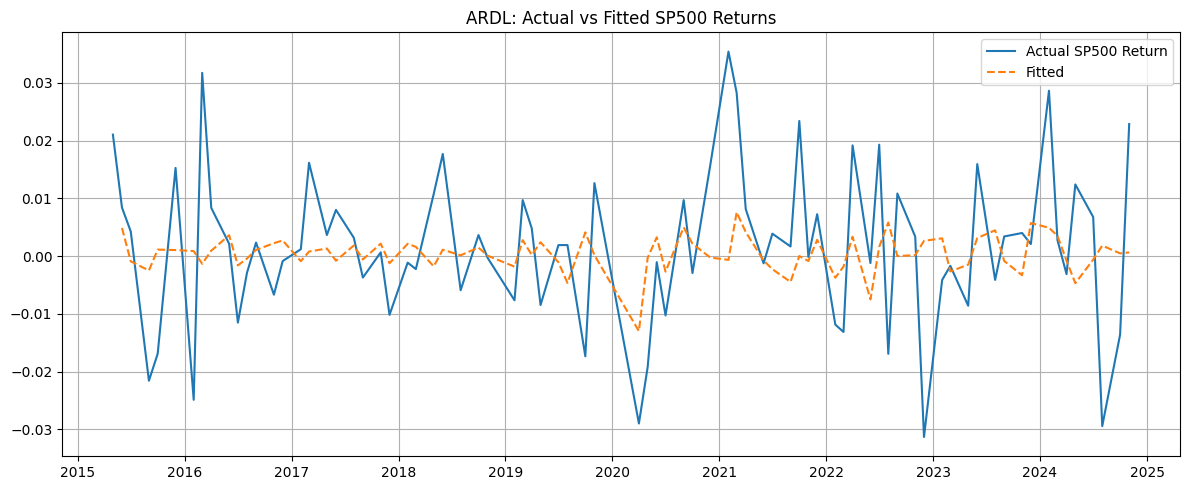

In [11]:
#因為CCI ADF無法拒絕單根（p=0.7125），KPSS 拒絕穩定（p=0.0100）→ 雙重證明不穩定！
#所以VAR和VECM皆不能用
#使用ARDL
# 建立 ARDL 模型
# 設定應變數與自變數
y = df['SP500_ret']
x = df[['VIX', 'CCI_diff']]

# 建立 ARDL 模型（此處以 (1, 1, 1) 為例：應變數滯後1，自變數各1期）
model = ARDL.from_formula("SP500_ret ~ VIX + CCI_diff", data=df, lags=1)
result = model.fit()
print(result.summary())

# 加入預測值
df['fitted'] = result.fittedvalues

# 預測圖
plt.figure(figsize=(12, 5))
plt.plot(df['SP500_ret'], label='Actual SP500 Return')
plt.plot(df['fitted'], label='Fitted', linestyle='--')
plt.title('ARDL: Actual vs Fitted SP500 Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()